### Train the model

In [1]:
import os
os.chdir("/Users/hxi/University/DL/DeepPhase4Audio")

In [2]:
!./train_yaml.sh

^CTraceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/hxi/.pyenv/versions/3.10.4/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main

    exitcode = _main(fd, parent_sentinel)
  File "/Users/hxi/.pyenv/versions/3.10.4/lib/python3.10/multiprocessing/spawn.py", line 125, in _main
    prepare(preparation_data)
  File "/Users/hxi/.pyenv/versions/3.10.4/lib/python3.10/multiprocessing/spawn.py", line 234, in prepare
    _fixup_main_from_name(data['init_main_from_name'])
  File "/Users/hxi/.pyenv/versions/3.10.4/lib/python3.10/multiprocessing/spawn.py", line 258, in _fixup_main_from_name
    main_content = runpy.run_module(mod_name,
  File "/Users/hxi/.pyenv/versions/3.10.4/lib/python3.10/runpy.py", line 209, in run_module
    return _run_module_code(code, init_globals, run_name, mod_spec)
  File "/Users/hxi/.pyenv/versions/3.10.4/lib/python3.10/runpy.py", line 96, in _run_module_code
    _run_code(code, mod_globals, init_globals,
  File "/Us

### Test Reconstruction


##### Load the model and set it to eval mode

In [3]:
import pytorch_lightning as pl
import os

from src.experiments.pae_flattened import PAEInputFlattenedModel
from src.utils.config import load_config

cfg_path = "configs/baseline.yaml"
model_ckpt_path = "logs/checkpoints/random_50eps_dilation=5_intch=128.ckpt"

cfg = load_config(cfg_path, flatten=True)
lightning_model = PAEInputFlattenedModel.load_from_checkpoint(model_ckpt_path, cfg=cfg)
model = lightning_model.model

print(model)

Number of samples in train split: 155
Number of samples in valid split: 19
Number of samples in test split: 20
Custom logic when loading checkpoint
PAEInputFlattened(
  (conv1): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=same, dilation=(5,))
  (norm1): LN_v2()
  (conv2): Conv1d(128, 5, kernel_size=(7,), stride=(1,), padding=same, dilation=(5,))
  (fc): ModuleList(
    (0-4): 5 x Linear(in_features=32000, out_features=2, bias=True)
  )
  (deconv1): Conv1d(5, 128, kernel_size=(7,), stride=(1,), padding=same, dilation=(5,))
  (denorm1): LN_v2()
  (deconv2): Conv1d(128, 1, kernel_size=(7,), stride=(1,), padding=same, dilation=(5,))
)


##### Load data and test model

In [ ]:
from src.datasets.data_processing import AudioDataset

model.eval()

# load dataset
D_test = AudioDataset(dataset_root='data', split='test')
D_train = AudioDataset(dataset_root='data', split='train')
x_train_sample = D_train[0]
x_test_sample = D_test[0]
print("test sample: ", x_test_sample)

# get model outputs
y, latent, signal, params = model(x_test_sample)

print("latent signal params (p, f, a, b): ", params)
print(f"orig signal shape: {x_test_sample.shape}, latent signal shape: {signal.shape}")


test sample:  tensor([[0.4888, 0.5241, 0.5241,  ..., 0.1353, 0.1818, 0.1386]])
latent signal params (p, f, a, b):  [tensor([[[-0.0877],
         [ 0.0926],
         [-0.0839],
         [-0.4916],
         [-0.2952]]], grad_fn=<UnsqueezeBackward0>), tensor([[[176.1822],
         [156.9792],
         [214.2811],
         [328.8510],
         [915.9527]]], grad_fn=<UnsqueezeBackward0>), tensor([[[0.2375],
         [0.2726],
         [0.1985],
         [0.1746],
         [0.0892]]], grad_fn=<UnsqueezeBackward0>), tensor([[[ 0.0012],
         [ 0.0015],
         [-0.0009],
         [ 0.0024],
         [ 0.0002]]], grad_fn=<UnsqueezeBackward0>)]
orig signal shape: torch.Size([1, 32000]), latent signal shape: torch.Size([1, 5, 32000])


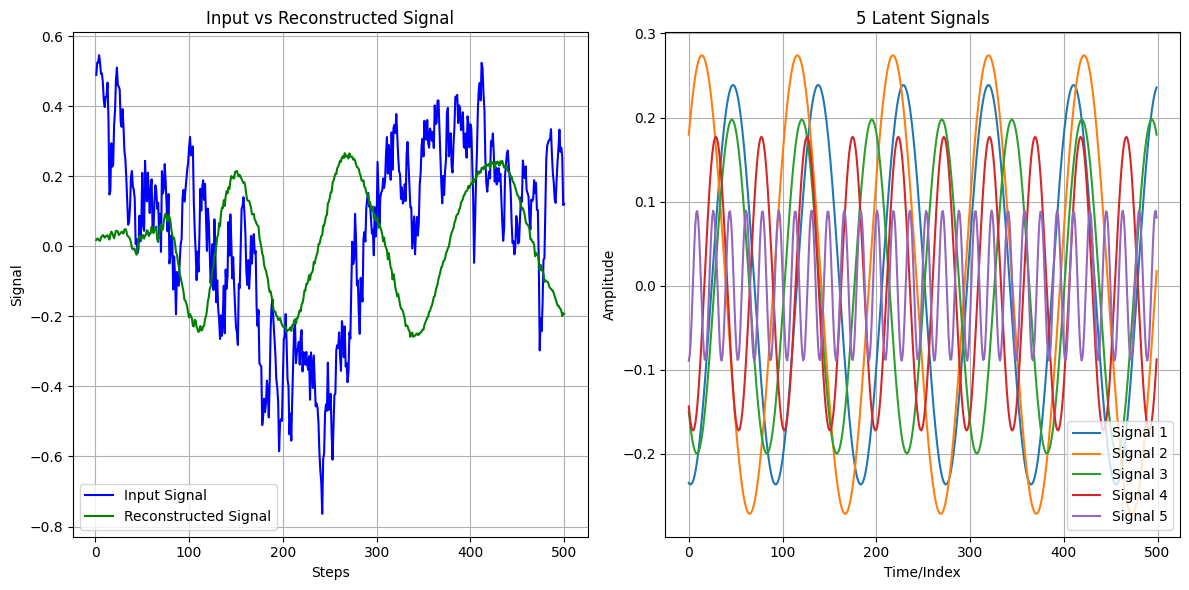

In [6]:
# plot the output against the input signal, and the latent signals
# Plot input signal x against output signal y
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

N = cfg.time_range
K = cfg.embedding_channels
T = 500 # only show T steps

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, T+1), x_test_sample.flatten()[:T], label="Input Signal", color="blue")
plt.plot(np.arange(1, T+1), y.detach().flatten()[:T], label="Reconstructed Signal", color="green")
plt.xlabel("Steps")
plt.ylabel("Signal")
plt.title("Input vs Reconstructed Signal")
plt.legend()
plt.grid()

# Plot each of the k signals in a different color
plt.subplot(1, 2, 2)
for i in range(K):
    plt.plot(range(T), signal[0, i, :T].detach(), label=f"Signal {i+1}")
plt.xlabel("Time/Index")
plt.ylabel("Amplitude")
plt.title(f"{K} Latent Signals")
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()

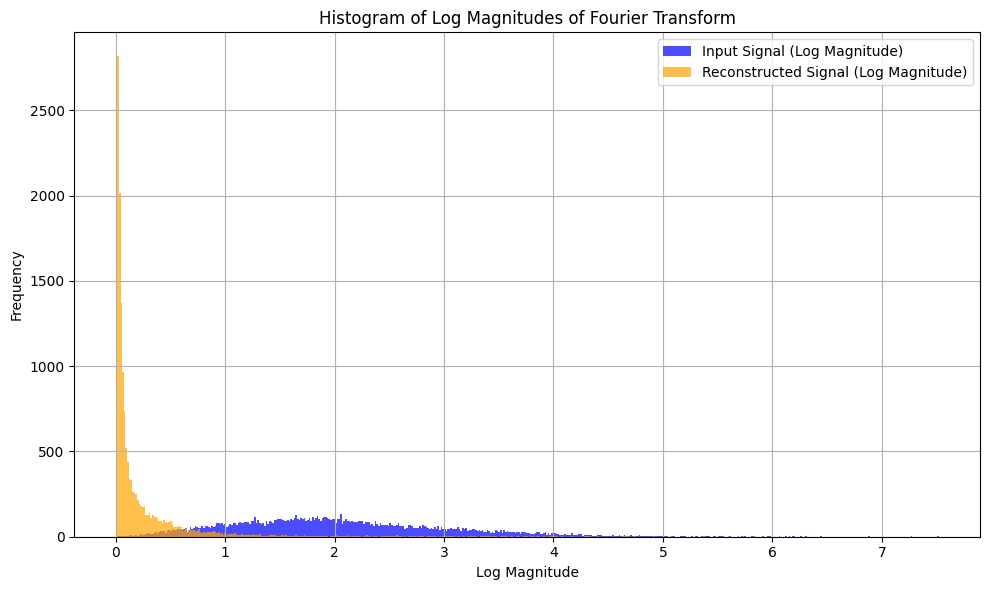

In [5]:
""" plot input and output (log) Spectograms """

# Compute Fourier Transforms
input_fft = np.fft.fft(x_test_sample.squeeze(0).numpy())
reconstructed_fft = np.fft.fft(y.squeeze(0).detach().numpy())

# Compute log magnitudes
log_magnitude_input = np.log1p(np.abs(input_fft)[:N // 2])
log_magnitude_reconstructed = np.log1p(np.abs(reconstructed_fft)[:N // 2])

# Create bins for histograms
n_bins = 500
bins = np.linspace(0, np.max([log_magnitude_input.max(), log_magnitude_reconstructed.max()]), 500)

# Plot histograms of the log magnitudes
plt.figure(figsize=(10, 6))

plt.hist(log_magnitude_input, bins=bins, alpha=0.7, label="Input Signal (Log Magnitude)", color="blue")
plt.hist(log_magnitude_reconstructed, bins=bins, alpha=0.7, label="Reconstructed Signal (Log Magnitude)", color="orange")

plt.title("Histogram of Log Magnitudes of Fourier Transform")
plt.xlabel("Log Magnitude")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# # Compute frequency axis
# freqs = np.fft.fftfreq(N, d=1)

# # Plot the Fourier Transform of the input signal
# plt.figure(figsize=(12, 6))

# plt.plot(freqs[:N // 2], np.abs(input_fft)[:N // 2], label="Input Signal")
# plt.plot(freqs[:N // 2], np.abs(reconstructed_fft)[:N // 2], label="Reconstructed Signal", color="orange")
# plt.title("Log Spectogram of Normalized Input and Reconstructed Signal")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Log Magnitude")
# plt.grid()
# plt.legend()

# plt.tight_layout()
# plt.show()